In [1]:
import os
import librosa
import librosa.display
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def pad_or_trim_mel_spec(mel_spec, max_length):
    # 获取当前梅尔谱图的时间维度长度
    length = mel_spec.shape[1]
    if length > max_length:
        # 裁剪
        mel_spec = mel_spec[:, :max_length]
    elif length < max_length:
        # 填充
        padding = max_length - length
        mel_spec = np.pad(mel_spec, ((0, 0), (0, padding)), mode='constant')
    return mel_spec

resize_transform = transforms.Resize((456, 456))

class GTZANDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, index):
        file_path = self.file_paths[index]
        label = self.labels[index]

        y, sr = librosa.load(file_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        max_length = 1300
        mel_spec = pad_or_trim_mel_spec(mel_spec, max_length)

        if self.transform:
            mel_spec = self.transform(mel_spec)
        else:
            mel_spec = torch.tensor(mel_spec).unsqueeze(0)

        mel_spec = resize_transform(mel_spec)

        return mel_spec, label

In [3]:
data_dir = './autodl-fs/Data/genres_original/'

genres = os.listdir(data_dir)

In [4]:
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [ ]:
file_paths = []
labels = []

for i , genre in enumerate(genres):
    genre_dir = os.path.join(data_dir, genre)
    cnt = 0
    for file in os.listdir(genre_dir):
        if file.endswith('.wav') and file != 'jazz.00054.wav':
            file_paths.append(os.path.join(genre_dir, file))
            labels.append(i)
            cnt += 1
    print("{} cnt: {}".format(genre, cnt))
print(file_paths)
print(labels)

In [6]:
len(file_paths)

999

In [7]:
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

In [8]:
class SpecAugment:
    def __call__(self, spec):
        spec = torch.tensor(spec)
        
        if spec.dim() == 2:
            spec = spec.unsqueeze(0)
        
        freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)
        time_mask = torchaudio.transforms.TimeMasking(time_mask_param=35)
        spec = freq_mask(spec)
        spec = time_mask(spec)
        return spec
    
train_transform = transforms.Compose([
    SpecAugment(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [9]:
train_dataset = GTZANDataset(train_files, train_labels, transform=train_transform)
test_dataset = GTZANDataset(test_files, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
dataiter = iter(train_loader)
mel_specs, labels = next(dataiter)
print(mel_specs)
print(labels)

tensor([[[[-139.4660, -155.5968, -158.3346,  ...,  -59.1353,   -1.0000,
             -1.0000],
          [-139.4660, -155.5968, -158.3346,  ...,  -59.1353,   -1.0000,
             -1.0000],
          [-132.7515, -149.4821, -154.4073,  ...,  -56.6276,   -1.0000,
             -1.0000],
          ...,
          [-161.0000, -161.0000, -161.0000,  ...,  -88.5327,   -1.0000,
             -1.0000],
          [-161.0000, -161.0000, -161.0000,  ...,  -88.5327,   -1.0000,
             -1.0000],
          [-161.0000, -161.0000, -161.0000,  ...,  -88.5327,   -1.0000,
             -1.0000]]],


        [[[ -39.2845,  -18.7335,  -25.7829,  ...,  -36.6158,   -1.0000,
             -1.0000],
          [ -39.2845,  -18.7335,  -25.7829,  ...,  -36.6158,   -1.0000,
             -1.0000],
          [ -37.4460,  -17.2379,  -25.3891,  ...,  -35.5213,   -1.0000,
             -1.0000],
          ...,
          [-161.0000, -161.0000, -161.0000,  ...,  -88.5327,   -1.0000,
             -1.0000],
          [-161.

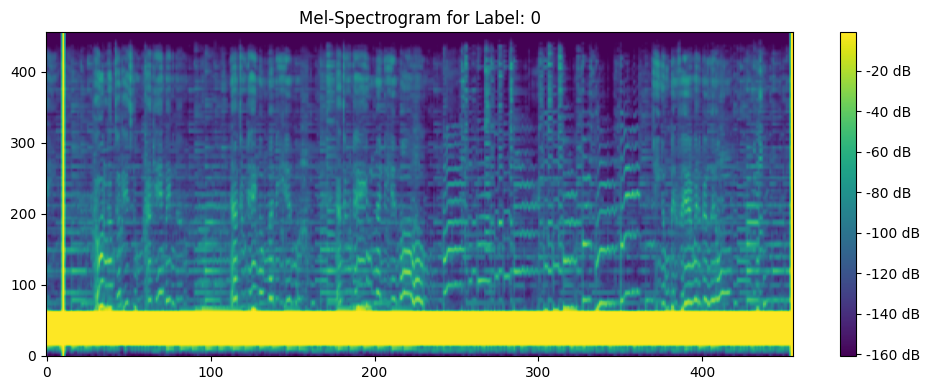

In [11]:
# 选择一个样本进行可视化
sample_idx = 0  # 可以改变这个索引来查看不同样本
mel_spec = mel_specs[sample_idx].squeeze(0).numpy()  # 获取第一个样本并移除额外的维度
label = labels[sample_idx].item()

# 绘制梅尔频谱图
def plot_mel_spectrogram(mel_spec, title="Mel-Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# 绘制样本梅尔频谱图
plot_mel_spectrogram(mel_spec, title=f"Mel-Spectrogram for Label: {label}")

In [12]:
model = models.efficientnet_b5(pretrained=True)

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model.features[0][0]

Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [14]:
model.features[0][0] = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [15]:
model.classifier[1]

Linear(in_features=2048, out_features=1000, bias=True)

In [16]:
model.classifier[1] = nn.Linear(in_features=2048, out_features=10, bias=True)

In [17]:
model.classifier[1]

Linear(in_features=2048, out_features=10, bias=True)

In [18]:
# model = models.vgg16(pretrained=True)

# model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# model.classifier[6] = nn.Linear(4096, 10)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [19]:
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # 切换模型到训练模式
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # 获取每个样本的预测类别
            total += labels.size(0)  # 样本总数
            correct += (predicted == labels).sum().item()  # 计算正确预测的样本数

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total  # 计算准确率
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
    torch.save(model.state_dict(), 'model.pth')

In [20]:
train(model, train_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Loss: 2.1011
Epoch 2/50, Loss: 1.5045
Epoch 3/50, Loss: 1.0418
Epoch 4/50, Loss: 0.7906
Epoch 5/50, Loss: 0.5704
Epoch 6/50, Loss: 0.4329
Epoch 7/50, Loss: 0.3128
Epoch 8/50, Loss: 0.2605
Epoch 9/50, Loss: 0.2098
Epoch 10/50, Loss: 0.2149
Epoch 11/50, Loss: 0.1584
Epoch 12/50, Loss: 0.0903
Epoch 13/50, Loss: 0.1181
Epoch 14/50, Loss: 0.1229
Epoch 15/50, Loss: 0.1065
Epoch 16/50, Loss: 0.0879
Epoch 17/50, Loss: 0.1031
Epoch 18/50, Loss: 0.0543
Epoch 19/50, Loss: 0.0895
Epoch 20/50, Loss: 0.0796
Epoch 21/50, Loss: 0.0516
Epoch 22/50, Loss: 0.0772
Epoch 23/50, Loss: 0.0455
Epoch 24/50, Loss: 0.0589
Epoch 25/50, Loss: 0.0509
Epoch 26/50, Loss: 0.0454
Epoch 27/50, Loss: 0.0389
Epoch 28/50, Loss: 0.0395
Epoch 29/50, Loss: 0.0562
Epoch 30/50, Loss: 0.0397
Epoch 31/50, Loss: 0.0396
Epoch 32/50, Loss: 0.0439
Epoch 33/50, Loss: 0.0367
Epoch 34/50, Loss: 0.0345
Epoch 35/50, Loss: 0.0368
Epoch 36/50, Loss: 0.0318
Epoch 37/50, Loss: 0.0265
Epoch 38/50, Loss: 0.0192
Epoch 39/50, Loss: 0.

In [21]:
model = models.efficientnet_b5(pretrained=False)
model.features[0][0] = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=2048, out_features=10, bias=True)
model.load_state_dict(torch.load('model.pth'))
model.to(device)

def evaluate(model, test_loader):
    model.eval()
    outputs = []
    targets = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device)
            output = model(inputs)
            _, preds = torch.max(output, 1)
            outputs.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    print("Classification Report: ")
    print(classification_report(targets, outputs, target_names=genres))
    print("Confusion Matrix: ")
    print(confusion_matrix(targets, outputs))

evaluate(model, test_loader)

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1750/2090842379.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

Classification Report: 
              precision    recall  f1-score   support

       blues       0.82      0.70      0.76        20
   classical       1.00      0.95      0.97        20
     country       0.93      0.65      0.76        20
       disco       0.65      0.65      0.65        20
      hiphop       0.77      0.85      0.81        20
        jazz       0.95      1.00      0.98        20
       metal       0.94      0.85      0.89        20
         pop       0.74      0.70      0.72        20
      reggae       0.71      0.75      0.73        20
        rock       0.59      0.85      0.69        20

    accuracy                           0.80       200
   macro avg       0.81      0.79      0.80       200
weighted avg       0.81      0.80      0.80       200

Confusion Matrix: 
[[14  0  0  2  0  0  0  0  1  3]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 1  0 13  0  0  0  0  0  1  5]
 [ 1  0  1 13  2  0  0  1  1  1]
 [ 0  0  0  1 17  0  0  2  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]


In [20]:
# model = models.efficientnet_b5(pretrained=False)
# model.features[0][0] = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# model.classifier[1] = nn.Linear(in_features=2048, out_features=10, bias=True)
# model.load_state_dict(torch.load('model.pth'))
# model.to(device)

# def evaluate(model, test_loader):
#     model.eval()
#     outputs = []
#     targets = []
    
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs = inputs.to(device, dtype=torch.float)
#             labels = labels.to(device)
#             output = model(inputs)
#             _, preds = torch.max(output, 1)
#             outputs.extend(preds.cpu().numpy())
#             targets.extend(labels.cpu().numpy())
#     print("Classification Report: ")
#     print(classification_report(targets, outputs, target_names=genres))
#     print("Confusion Matrix: ")
#     print(confusion_matrix(targets, outputs))

# evaluate(model, test_loader)

/tmp/ipykernel_1530/365973035.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Classification Report: 
              precision    recall  f1-score   support

       blues       0.87      0.65      0.74        20
   classical       1.00      1.00      1.00        20
     country       0.89      0.80      0.84        20
       disco       0.88      0.70      0.78        20
      hiphop       0.90      0.95      0.93        20
        jazz       0.91      1.00      0.95        20
       metal       1.00      0.95      0.97        20
         pop       0.76      0.95      0.84        20
      reggae       0.64      0.80      0.71        20
        rock       0.84      0.80      0.82        20

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200

Confusion Matrix: 
[[13  0  0  0  0  1  0  0  5  1]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 2  0 16  0  0  0  0  0  1  1]
 [ 0  0  0 14  1  1  0  2  2  0]
 [ 0  0  0  0 19  0  0  1  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
